Surface Water Volumetrics

# Imports

In [27]:
% matplotlib inline
import pandas as pd
import numpy as np
import xarray as xr
import rasterio
import sys
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import geopandas as gpd
import pyproj
import rasterio.mask
import gdal
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

sys.path.append('../Scripts')

# Functions

In [28]:
def bump(arr, direction, jump = 1):
    if direction == 'down':
        arr = np.roll(arr, jump, axis = 0)
        arr[0:jump,:] = np.nan
        return arr
    if direction == 'up':
        arr = np.roll(arr, -jump, axis = 0)
        arr[-jump::,:] = np.nan
        return arr
    if direction == 'left':
        arr = np.roll(arr, -jump, axis = 1)
        arr[:,-jump::] = np.nan
        return arr
    if direction == 'right':
        arr = np.roll(arr, jump, axis = 1)
        arr[:, 0:jump] = np.nan
        return arr
    if direction == 'none':
        return arr

In [29]:
def findClusters(arr, radius = 1):
    bumped = []
    directions = ['up','down','left','right', 'none']
    for rad in range(radius, radius + 1):
        for direction in directions:
            bumped.append(np.isfinite(bump(arr, direction, rad)))
    bumped = np.stack(bumped, axis = -1)
    
    return bumped.all(axis = -1)

In [30]:
def dfToXarray(df, cols):

    if isinstance(cols, str) or len(cols) == 1:
        ys = df['y'].unique()
        xs = df['x'].unique()
        ylen = len(ys)
        xlen = len(xs)
        data = df[cols].values.reshape(ylen, xlen)
        x = xr.DataArray(data, coords = {'y':ys,'x':xs}, dims = ['y','x'])
    else:
        ds = {}
        for col in cols:
            ds[col] = dfToXarray(df, col)
            x = xr.Dataset(ds)
    return x

In [31]:
def xarrayToDF(xarr):
    if isinstance(xarr, xr.DataArray):
        not_xy_vars = [var for var in xarr.coords if var not in ['x','y']]
        for var in not_xy_vars:
            if len(xarr[var].values == 1):
                xarr = xarr.squeeze(var)
                # save off as df
            # save off as df
    elif isinstance(xarr, xr.Dataset):
        vars = list(xarr.data_vars)
        

# Import Data

In [33]:
tcw_files_loc = r'\\prod.lan\active\proj\futurex\StuartCorridor\Data\Processed\RemoteSensing\Landsat\TCW\New\\'
as_tifs = [file for file in os.listdir(tcw_files_loc) if (file[0:12] == 'alicesprings') and (file[-4::] == '.tif')]
as2015 = as_tifs[2]
data = xr.open_rasterio(tcw_files_loc + as2015)
data

<xarray.DataArray (band: 1, y: 2924, x: 3798)>
[11105352 values with dtype=float64]
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 -2.527e+06 -2.527e+06 -2.527e+06 -2.527e+06 ...
  * x        (x) float64 1.519e+05 1.52e+05 1.52e+05 1.52e+05 1.52e+05 ...
Attributes:
    crs:      +init=epsg:3577

In [37]:
df = data.to_dataframe(name='wet_frac')
df = df.reset_index(drop=False)
df = df.drop(labels = 'band', axis = 1)
df.head()

df['wet_flag'] = df['wet_frac']
df.loc[df[df['wet_flag'] != 0].index, 'wet_flag'] = 1

wet_df = df[df['wet_flag'] == 1][['y','x']]
wet_vals = wet_df.values
wet_df.head()

,y,x
3165,-2526550.0,231050.0
3166,-2526550.0,231075.0
3167,-2526550.0,231100.0
6963,-2526575.0,231050.0
6964,-2526575.0,231075.0


In [38]:
df.loc[[3165, 3166, 3167]]

,y,x,wet_frac,wet_flag
3165,-2526550.0,231050.0,0.5,1.0
3166,-2526550.0,231075.0,0.5,1.0
3167,-2526550.0,231100.0,0.5,1.0


In [39]:
scaler = preprocessing.StandardScaler().fit(wet_vals)
wet_vals = scaler.transform(wet_vals)
# wet_vals = preprocessing.normalize(wet_vals)

km = MiniBatchKMeans(n_clusters = 50, random_state = 42).fit(wet_vals)
wet_df['clust_num'] = km.labels_

# km = DBSCAN(min_samples = 500).fit(wet_vals)
# wet_df['clust_num'] = km.labels_
# wet_df.head()

In [40]:
res = pd.merge(df, wet_df[['clust_num']], how = 'left', left_index = True, right_index = True )
res.head()

,y,x,wet_frac,wet_flag,clust_num
0,-2526550.0,151925.0,0.0,0.0,NaN
1,-2526550.0,151950.0,0.0,0.0,NaN
2,-2526550.0,151975.0,0.0,0.0,NaN
3,-2526550.0,152000.0,0.0,0.0,NaN
4,-2526550.0,152025.0,0.0,0.0,NaN


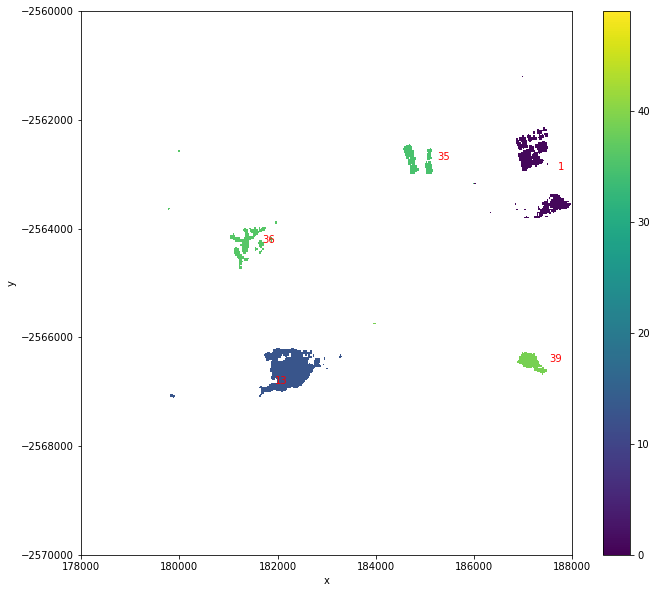

In [41]:
res_xr = dfToXarray(res, 'clust_num')
res_xr.plot.imshow(figsize=[11,10], cmap = 'viridis')
xmin = 178000
xmax = 188000
ymin = -2570000
ymax = -2560000
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
for clust in wet_df['clust_num'].unique():
    xloc = wet_df[wet_df['clust_num'] == clust]['x'].mean()
    yloc = wet_df[wet_df['clust_num'] == clust]['y'].mean()
    if (xmin <= xloc <= xmax) and (ymin <= yloc <= ymax):
        plt.plot([xloc,yloc],'ro')
        plt.annotate(clust,[xloc, yloc], xytext = [20,0], textcoords = 'offset points', color = 'red')

In [46]:
results = {'before':[], 'after':[]}
for clust in res['clust_num'].unique():
    results['before'].append(len(res[(res['clust_num'] == clust) & (res['wet_frac'] == 1)]))
    results['after'].append(len(res[(res['clust_num'] == clust) & (res['wet_frac'] == 0.5)]))

pd.DataFrame(results)

,after,before
0,0,0
1,248,0
2,29,1
3,93,0
4,88,0
5,646,0
6,127,5
7,19,2
8,119,0
9,301,0


In [45]:
(res['clust_num'] == clust).head()
# len(res[(res['clust_num'] == clust) & (res[res['wet_frac'] == 1])])
# len(res[(res['clust_num'] == clust) & (res[res['wet_frac'] == 1])])

0    False
1    False
2    False
3    False
4    False
Name: clust_num, dtype: bool

In [34]:
# hyperparams = {'classifier__C': [1, 0.5, .1, .01],
#               'classifier__class_weight':[None,'balanced']}

preprocess = Pipeline([('scale', preprocessing.StandardScaler()),
                      ('normalize', preprocessing.Normalizer())])

allsteps = Pipeline([('preprocess', preprocess),
                       ('classifier', KMeans(n_clusters = 10, random_state = 42))])
allsteps.fit(df[['x','y']].values)


AttributeError: 'Pipeline' object has no attribute 'labels_'

# Clustering

In [16]:
kmeans = KMeans(n_clusters = 10, random_state = 42).fit(df.values)
df['cluster_num'] = kmeans.labels_

KeyboardInterrupt: 

In [30]:
dfToXarray(df,[col for col in df.columns if col not in ['x','y']])

<xarray.DataArray (y: 2924, x: 3798)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * y        (y) float64 -2.527e+06 -2.527e+06 -2.527e+06 -2.527e+06 ...
  * x        (x) float64 1.519e+05 1.52e+05 1.52e+05 1.52e+05 1.52e+05 ...

In [27]:
ys = df['y'].unique()
xs = df['x'].unique()
ylen = len(ys)
xlen = len(xs)
data = df[cols].values.reshape(ylen, xlen)
x = xr.DataArray(data, coords = {'y':ys,'x':xs}, dims = ['y','x'])
df

,y,x,frac_wet
0,-2526550.0,151925.0,0.0
1,-2526550.0,151950.0,0.0
2,-2526550.0,151975.0,0.0
3,-2526550.0,152000.0,0.0
4,-2526550.0,152025.0,0.0
5,-2526550.0,152050.0,0.0
6,-2526550.0,152075.0,0.0
7,-2526550.0,152100.0,0.0
8,-2526550.0,152125.0,0.0
9,-2526550.0,152150.0,0.0


In [ ]:
preprocess = Pipeline([('scale', preprocessing.StandardScaler()),
                      ('normalize', preprocessing.Normalizer())])

allsteps = Pipeline([('preprocess', preprocess),
                       ('classifier', LogisticRegression(solver = 'sag', multi_class = 'multinomial'))])
allsteps.fit(X_train , y_train)#, {)
preds = allsteps.predict(X_test)
np.mean(preds == y_test)

# Other Stuff

In [136]:
with rasterio.open(tcw_files_loc + as_tifs[2], 'r') as f:
    as2015 = f.read()

In [137]:
as2015 = as2015.squeeze()
as2015[as2015 == 0] = np.nan
as2015 = np.flipud(as2015)
as2015

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [178]:
waterbods = findClusters(as2015, 6).astype(np.float32)
waterbods[waterbods == 0] = np.nan


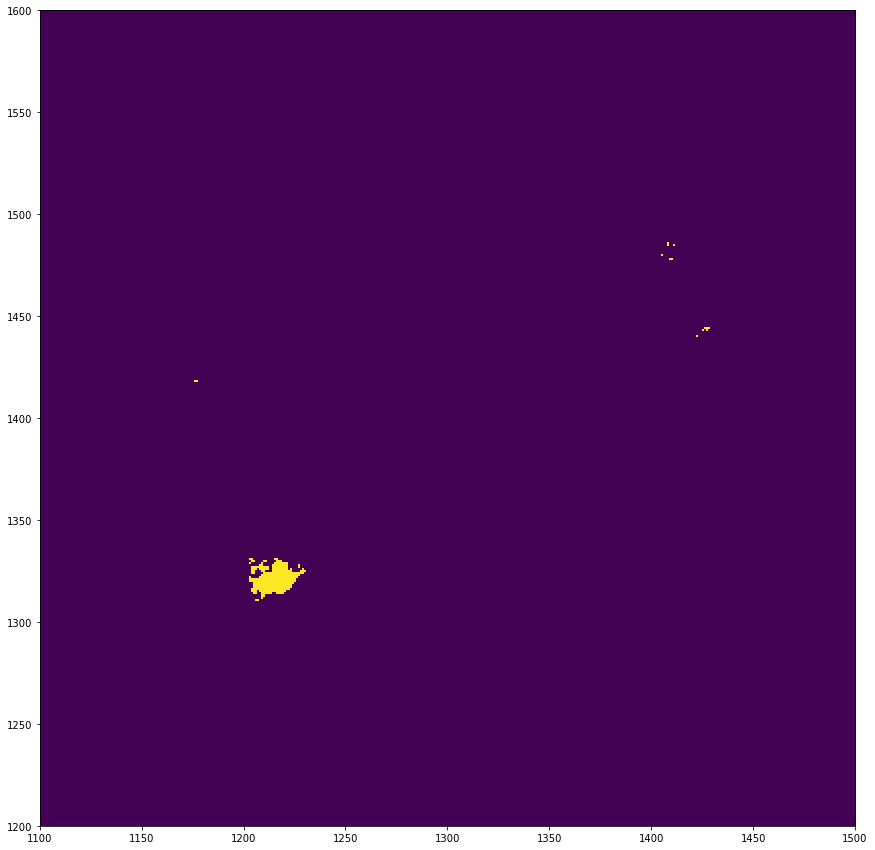

In [179]:
plt.figure(figsize = [15,15])
# imshow(as2015)
plt.ylim([1200,1600])
plt.xlim([1100,1500])
# imshow(waterbods, cmap = 'inferno')
imshow((np.isfinite(waterbods) & (as2015 == 0.5)).astype(dtype = np.int8)) 
plt.show()

In [185]:
dem_loc = r'\\prod.lan\active\proj\futurex\StuartCorridor\Data\Processed\ElevationDepth\Elevation\\'
with rasterio.open(dem_loc + 'SSC_SRTM1s_DEM_clip.tif') as f:
    elev = f.read().squeeze()
imshow(elev)

MemoryError: 

154315.29363 -2528764.70906 243773.560684 -2596599.63025


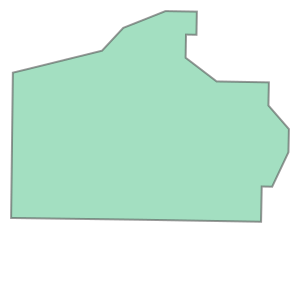

In [172]:
eftf_polys_loc = r'\\prod.lan\active\proj\futurex\StuartCorridor\Data\Processed\Boundaries\Extents\EFTF_extentsMarch2107\\'
eftf_polys = gpd.read_file(eftf_polys_loc + 'EFTF_extents_March_2017.shp').to_crs(data.attrs['crs'])
as_poly = eftf_polys.loc[3, 'geometry']
tlx, tly, brx, bry = np.array(as_poly.exterior.coords)[:,0].min(), np.array(as_poly.exterior.coords)[:,1].max(), np.array(as_poly.exterior.coords)[:,0].max(), np.array(as_poly.exterior.coords)[:,1].min()
print(tlx, tly, brx, bry)
as_poly

In [157]:
as_poly.exterior.coords[0]

(210517.7634831361, -2543788.2208628096)

In [160]:
dem_loc = r'\\prod.lan\active\proj\futurex\StuartCorridor\Data\Processed\ElevationDepth\Elevation\\'
with rasterio.open(dem_loc + 'SSC_SRTM1s_DEM_clip.tif') as f:
    out_meta = f.meta.copy()
    out_image = rasterio.mask.mask(f, [as_poly], crop=True)
    out_meta = f.meta.copy()
imshow(out_image)

TypeError: argument of type 'Polygon' is not iterable

In [220]:
with fiona.open(eftf_polys_loc + 'EFTF_extents_March_2017.shp', "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
# features = features[3]
features

[{'coordinates': [[(131.02560000000005, -14.373266999999942),
    (130.8320000001488, -13.530500000386724),
    (130.92290693456016, -13.335732674001292),
    (131.4832700014332, -13.64625233526209),
    (132.47907443237318, -14.770547660516911),
    (132.00437196171004, -15.291649620793748),
    (131.02560000000005, -14.373266999999942)]],
  'type': 'Polygon'},
 {'coordinates': [[(130.89793157546478, -12.867899596575967),
    (130.89793157546478, -12.12944940121821),
    (131.3921339473195, -12.12944940121821),
    (131.3921339473195, -12.867899596575967),
    (130.89793157546478, -12.867899596575967)]],
  'type': 'Polygon'},
 {'coordinates': [[(134.331223915, -20.33189202299991),
    (133.41788410000004, -20.331895319999944),
    (133.41787227300006, -19.198040049999918),
    (134.33121611800004, -19.657459694999943),
    (134.331223915, -20.33189202299991)]],
  'type': 'Polygon'},
 {'coordinates': [[(134.08333600000003, -23.566663999999946),
    (134.18333600000005, -23.633330999999

In [56]:
np.array([[True,True,False],[True, False,False]]).all(axis =0)

array([ True, False, False], dtype=bool)

In [76]:
bumped = np.stack([np.isfinite(bump(test, direction)) for direction in directions], axis = -1)
bumped

array([[[False, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False],
        [ True, False, False, False, False]],

       [[False, False,  True, False, False],
        [ True, False,  True, False,  True],
        [ True, False,  True,  True,  True],
        [ True, False, False,  True,  True]],

       [[False, False,  True, False, False],
        [ True,  True,  True, False,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True, False,  True,  True]],

       [[False, False,  True, False, False],
        [False,  True,  True, False,  True],
        [False,  True,  True,  True,  True],
        [False,  True, False,  True,  True]]], dtype=bool)

In [79]:
bumped.all(axis = -1)

array([[False, False, False, False],
       [False, False, False, False],
       [False, False,  True, False],
       [False, False, False, False]], dtype=bool)

In [65]:
bump(test,'down')

array([[ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan],
       [ nan,   1.,   2.,   3.],
       [ nan,   4.,   5.,   6.]])

In [171]:
tlx, tly, brx, bry = np.array(as_poly.exterior.coords)[:,0].min(), np.array(as_poly.exterior.coords)[:,1].max(), np.array(as_poly.exterior.coords)[:,0].max(), np.array(as_poly.exterior.coords)[:,1].min()
print(tlx, tly, brx, bry)

154315.29363 -2528764.70906 243773.560684 -2596599.63025


In [168]:
np.array(as_poly.exterior.coords)

array([[  210517.76348314, -2543788.22086281],
       [  220494.16495491, -2551415.42215797],
       [  237323.96262334, -2551714.05127204],
       [  237186.74662688, -2559172.83241316],
       [  243773.56068427, -2566757.7709892 ],
       [  243632.4281627 , -2574217.76481596],
       [  238384.90804309, -2585314.48712902],
       [  235024.22465019, -2585249.19194864],
       [  234816.89998044, -2596599.63024585],
       [  195428.11677086, -2595940.52269819],
       [  154315.29363001, -2595381.31372212],
       [  154675.38129431, -2565380.61080743],
       [  154876.94529914, -2548595.72239085],
       [  183599.85567715, -2541512.28902113],
       [  190446.96552629, -2534151.8736378 ],
       [  204017.20331896, -2528764.70905966],
       [  214132.84333355, -2528928.36118618],
       [  214009.27875237, -2536385.66496162],
       [  210639.392441  , -2536330.26701654],
       [  210517.76348314, -2543788.22086281]])